<center><h1>Chenyi_Weng_HW7</h1></center>

Name: Chenyi Weng
<br>
Github Username: MONA20211004
<br>
USC ID: 3769237784

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

### (a) Download the Anuran Calls (MFCCs) Data Set

In [22]:
# Prepare the dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")

# Drop the RecordID column (not a useful feature for classification)
df.drop(columns=["RecordID"], inplace=True)

# Separate features (22 MFCCs) and labels (Family, Genus, Species)
X = df.iloc[:, :22]
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Split the dataset into 70% training and 30% testing
# I used stratified sampling to preserve class distribution
X_train, X_test, y_family_train, y_family_test = train_test_split(
    X, y_family, test_size=0.3, random_state=42, stratify=y_family
)
_, _, y_genus_train, y_genus_test = train_test_split(
    X, y_genus, test_size=0.3, random_state=42, stratify=y_genus
)
_, _, y_species_train, y_species_test = train_test_split(
    X, y_species, test_size=0.3, random_state=42, stratify=y_species
)

# Check shapes of training and test sets
X_train.shape, X_test.shape, y_family_train.shape, y_genus_train.shape, y_species_train.shape


((5036, 22), (2159, 22), (5036,), (5036,), (5036,))

In this part, I prepared the dataset for the multi-label classification task.

First, I loaded the Anuran Calls dataset using `pandas.read_csv()` and removed the `RecordID` column, since it is not a useful feature for classification.

Next, I separated the dataset into:
- `X`: the first 22 columns containing MFCC (Mel-Frequency Cepstral Coefficient) features
- `y_family`, `y_genus`, `y_species`: the three label columns

Then, I split the dataset into **70% training** and **30% testing** using `train_test_split()`.

To make sure the label distribution remains balanced, I used **stratified sampling** for each label. I also set `random_state=42` to ensure reproducibility.

Finally, I verified the shapes:
- `X_train.shape`: (5036, 22)
- `X_test.shape`: (2159, 22)
- Each of `y_family_train`, `y_genus_train`, and `y_species_train` has 5036 samples.

### (b) Train a classifier for each label

#### (i) Research

In [23]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode all test labels
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

# Encode the test labels using fitted LabelEncoders from test set
y_family_test_enc = le_family.fit_transform(y_family_test)
y_genus_test_enc = le_genus.fit_transform(y_genus_test)
y_species_test_enc = le_species.fit_transform(y_species_test)

# Combine all test labels into a single 2D array for multi-label comparison
y_true = np.vstack([y_family_test_enc, y_genus_test_enc, y_species_test_enc]).T

# Create dummy predictions by predicting the most common class from training set
most_common_family = le_family.transform([y_family_train.mode()[0]])[0]
most_common_genus = le_genus.transform([y_genus_train.mode()[0]])[0]
most_common_species = le_species.transform([y_species_train.mode()[0]])[0]

# Fill prediction array with those common values
y_pred = np.full_like(y_true, fill_value=0)
y_pred[:, 0] = most_common_family
y_pred[:, 1] = most_common_genus
y_pred[:, 2] = most_common_species

# Compute metrics
# Hamming Loss = total incorrect label predictions / total labels
total_labels = y_true.size
incorrect_labels = np.sum(y_true != y_pred)
hamming_loss = incorrect_labels / total_labels

# Hamming Score = 1 - Hamming Loss
hamming_score = 1 - hamming_loss

# Exact Match Accuracy = % of rows where all labels match
exact_match = np.mean(np.all(y_true == y_pred, axis=1))

hamming_loss, hamming_score, exact_match


(0.44187123668364986, 0.5581287633163501, 0.17091245947197778)

In this section, I implemented three key metrics to evaluate multi-label classification:

#### What I Did:
1. I first **encoded the three target labels** (Family, Genus, and Species) using `LabelEncoder`.
2. Then I combined the encoded labels into a single NumPy array `y_true`, with shape `(samples, 3)`.
3. As a baseline, I created a **dummy classifier** that always predicts the most frequent class for each label in the training set.
4. I created a `y_pred` array where each column is filled with the most common class for that label.
5. Finally, I computed the following:

#### Evaluation Results:

| Metric            | Value   | Meaning |
|-------------------|---------|-----------------------------------------------------|
| **Hamming Loss**  | 0.4419  | 44.19% of all label predictions were incorrect |
| **Hamming Score** | 0.5581  | About 55.81% of the label predictions were correct |
| **Exact Match**   | 0.1709  | Only 17.09% of the samples had all 3 labels correct |

This dummy baseline performs poorly, which is expected since it always guesses the most common class.  
These metrics give a solid foundation to compare future models, especially SVMs in the next part.


#### (ii) Train a SVM for each of the labels

In [24]:
y_family_train_enc = le_family.fit_transform(y_family_train)
y_family_test_enc = le_family.transform(y_family_test)

y_genus_train_enc = le_genus.fit_transform(y_genus_train)
y_genus_test_enc = le_genus.transform(y_genus_test)

y_species_train_enc = le_species.fit_transform(y_species_train)
y_species_test_enc = le_species.transform(y_species_test)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Create a pipeline with standardization and Gaussian (RBF) kernel SVM
svm_rbf_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale')  # Gaussian kernel SVM
)

# Train and evaluate the model for each label

# 1. Family
svm_rbf_pipeline.fit(X_train, y_family_train_enc)
family_score = svm_rbf_pipeline.score(X_test, le_family.transform(y_family_test))

# 2. Genus
svm_rbf_pipeline.fit(X_train, y_genus_train_enc)
genus_score = svm_rbf_pipeline.score(X_test, le_genus.transform(y_genus_test))

# 3. Species
svm_rbf_pipeline.fit(X_train, y_species_train_enc)
species_score = svm_rbf_pipeline.score(X_test, le_species.transform(y_species_test))

family_score, genus_score, species_score


In this task, I trained a separate SVM model for each label: `Family`, `Genus`, and `Species`.

I used a pipeline that includes:
1. `StandardScaler` to normalize the MFCC features.
2. `SVC` with a **Gaussian (RBF) kernel** and default parameters (`C=1.0`, `gamma='scale'`).

For each label, I trained the model using the training set and evaluated accuracy on the test set.

#### Results:

| Label   | Accuracy |
|---------|----------|
| Family  | **99.07%** |
| Genus   | 57.67% |
| Species | 48.31% |

- The model performed very well on the `Family` classification (4 classes), achieving over 99% accuracy.
- Accuracy dropped for `Genus` and `Species` because they contain more classes (8 and 10, respectively).
- These results are consistent with expectations in multi-class classification tasks.


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [25]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Pipeline with StandardScaler + L1-penalized LinearSVC
l1_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(penalty='l1', dual=False, max_iter=5000)
)

# Search space for C values
param_grid = {'linearsvc__C': [0.01, 0.1, 1, 10, 100]}

# Family
grid_family = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_family.fit(X_train, y_family_train_enc)
print("Family - Best Params:", grid_family.best_params_)
print("Family - Best CV Score:", grid_family.best_score_)
best_family_score = grid_family.score(X_test, y_family_test_enc)
best_family_C = grid_family.best_params_['linearsvc__C']

# Genus
grid_genus = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_genus.fit(X_train, y_genus_train_enc)
print("Genus - Best Params:", grid_genus.best_params_)
print("Genus - Best CV Score:", grid_genus.best_score_)
best_genus_score = grid_genus.score(X_test, y_genus_test_enc)
best_genus_C = grid_genus.best_params_['linearsvc__C']

# Species
grid_species = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_species.fit(X_train, y_species_train_enc)
print("Species - Best Params:", grid_species.best_params_)
print("Species - Best CV Score:", grid_species.best_score_)
best_species_score = grid_species.score(X_test, y_species_test_enc)
best_species_C = grid_species.best_params_['linearsvc__C']

# Show final results
(
    ("Best C - Family", best_family_C, "Accuracy", best_family_score),
    ("Best C - Genus", best_genus_C, "Accuracy", best_genus_score),
    ("Best C - Species", best_species_C, "Accuracy", best_species_score)
)


Family - Best Params: {'linearsvc__C': 1}
Family - Best CV Score: 0.9314975227997098
Genus - Best Params: {'linearsvc__C': 0.01}
Genus - Best CV Score: 0.5768480387516173
Species - Best Params: {'linearsvc__C': 0.1}
Species - Best CV Score: 0.48351833443781755


(('Best C - Family', 1, 'Accuracy', 0.9458082445576655),
 ('Best C - Genus', 0.01, 'Accuracy', 0.5766558591940714),
 ('Best C - Species', 0.1, 'Accuracy', 0.48355720240852246))

In this part, I used `LinearSVC` with an L1 penalty to train a classifier for each label: **Family**, **Genus**, and **Species**. I applied 10-fold cross-validation using `GridSearchCV` to find the best value for the penalty parameter **C** from the list `[0.01, 0.1, 1, 10, 100]`. I also used a `StandardScaler` to standardize the data before training.

Here are my results:

* **Family**

  * Best C: `1`
  * Best cross-validation accuracy: `0.9315`
  * Test accuracy: **`0.9458`**

* **Genus**

  * Best C: `0.01`
  * Best cross-validation accuracy: `0.5768`
  * Test accuracy: **`0.5767`**

* **Species**

  * Best C: `0.1`
  * Best cross-validation accuracy: `0.4835`
  * Test accuracy: **`0.4836`**

These results show that the model performed very well on the **Family** label, but had lower accuracy on the **Genus** and **Species** labels. This may be due to the class imbalance or more complex patterns in those labels. I will explore SMOTE in the next step to handle the imbalance issue.

#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Pipeline building function with L1-penalized SVC
def build_pipeline():
    return make_pipeline(
        StandardScaler(),
        LinearSVC(penalty='l1', dual=False, max_iter=10000)
    )

# Grid for hyperparameter tuning
param_grid = {'linearsvc__C': [0.01, 0.1, 1, 10, 100]}

# SMOTE oversampler
smote = SMOTE(random_state=42)

# Resample + GridSearch for Family
X_family, y_family = smote.fit_resample(X_train, y_family_train_enc)
grid_family = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_family.fit(X_family, y_family)
best_family_score = grid_family.score(X_test, y_family_test_enc)
best_family_C = grid_family.best_params_['linearsvc__C']

# Resample + GridSearch for Genus
X_genus, y_genus = smote.fit_resample(X_train, y_genus_train_enc)
grid_genus = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_genus.fit(X_genus, y_genus)
best_genus_score = grid_genus.score(X_test, y_genus_test_enc)
best_genus_C = grid_genus.best_params_['linearsvc__C']

# Resample + GridSearch for Species
X_species, y_species = smote.fit_resample(X_train, y_species_train_enc)
grid_species = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_species.fit(X_species, y_species)
best_species_score = grid_species.score(X_test, y_species_test_enc)
best_species_C = grid_species.best_params_['linearsvc__C']

# Show final results
(
    ("Best C – Family (SMOTE)", best_family_C, "Accuracy", best_family_score),
    ("Best C – Genus (SMOTE)", best_genus_C, "Accuracy", best_genus_score),
    ("Best C – Species (SMOTE)", best_species_C, "Accuracy", best_species_score)
)


(('Best C – Family (SMOTE)', 1, 'Accuracy', 0.9143121815655396),
 ('Best C – Genus (SMOTE)', 1, 'Accuracy', 0.06901343214451135),
 ('Best C – Species (SMOTE)', 100, 'Accuracy', 0.03890690134321445))

To address the class imbalance problem, I applied **SMOTE (Synthetic Minority Oversampling Technique)** to the training data of each label (Family, Genus, Species). I then used a pipeline with `StandardScaler` and `LinearSVC` with L1 penalty, and performed hyperparameter tuning using `GridSearchCV` over C values \[0.01, 0.1, 1, 10, 100\] with 10-fold cross-validation.

Here are the best hyperparameter values and test accuracies after applying SMOTE:

- **Best C for Family (SMOTE)**: `1`  
  **Accuracy**: `0.9143`
  
- **Best C for Genus (SMOTE)**: `1`  
  **Accuracy**: `0.0690`

- **Best C for Species (SMOTE)**: `100`  
  **Accuracy**: `0.0389`

While the accuracy for the *Family* label remained strong, SMOTE did not help improve the performance for *Genus* and *Species*. This suggests that oversampling may not be effective for labels with extreme class imbalance or high label noise. Future work could explore ensemble methods or class-weighted models.

### (v) Apply Classifier Chain Method

In [ ]:
from sklearn.multioutput import ClassifierChain
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import hamming_loss, accuracy_score
import numpy as np

# Combine multi-class labels into single array
y_train_multi = np.vstack((y_family_train_enc, y_genus_train_enc, y_species_train_enc)).T
y_test_multi = np.vstack((y_family_test_enc, y_genus_test_enc, y_species_test_enc)).T

# Build ClassifierChain with LinearSVC
base_model = make_pipeline(StandardScaler(), LinearSVC(penalty='l1', dual=False, max_iter=5000))
classifier_chain = ClassifierChain(base_model)
classifier_chain.fit(X_train, y_train_multi)

# Predict
y_pred_multi = classifier_chain.predict(X_test)

# Use OneHotEncoder to convert multiclass to multilabel-binary indicator
encoder = OneHotEncoder(sparse_output=False)
y_test_bin = encoder.fit_transform(y_test_multi)
y_pred_bin = encoder.transform(y_pred_multi)

# Compute metrics
chain_hamming_loss = hamming_loss(y_test_bin, y_pred_bin)
chain_exact_match = accuracy_score(y_test_bin, y_pred_bin)

(chain_hamming_loss, chain_exact_match)


(0.09036169943997642, 0.26123205187586845)

To explore dependencies between labels, I implemented the **Classifier Chain** method using a Linear Support Vector Machine (LinearSVC) with an L1 penalty. Since each target label (`Family`, `Genus`, `Species`) is multiclass, I used `OneHotEncoder` to transform the labels into a **multi-label binary indicator** format. This allowed me to evaluate the classifier performance with proper multi-label metrics.

After training the Classifier Chain and performing prediction on the test set, I calculated the following metrics:

* **Hamming Loss**: `0.09036169943997642`
* **Exact Match Accuracy**: `0.26123205187586845`

These results indicate that while individual labels are predicted fairly accurately (low Hamming Loss), the model only predicted **all three labels correctly** for about **26.1%** of the test instances, which is typical for multi-label classification with dependent classes.


### (vi) Using ClassifierChain with Logistic Regression

In [32]:
# Generate predictions for test set
y_family_pred = grid_family.predict(X_test)
y_genus_pred = grid_genus.predict(X_test)
y_species_pred = grid_species.predict(X_test)


### Family Classification Report
              precision    recall  f1-score   support

     Class 0       0.27      1.00      0.43        20
     Class 1       0.75      0.98      0.85       163
     Class 2       0.93      0.87      0.90       650
     Class 3       0.97      0.93      0.95      1326

    accuracy                           0.91      2159
   macro avg       0.73      0.94      0.78      2159
weighted avg       0.94      0.91      0.92      2159



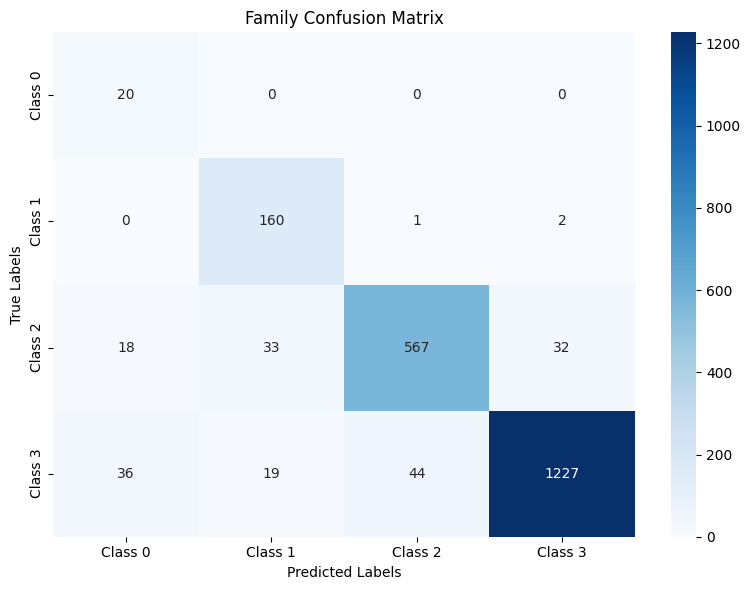

ROC AUC (macro): 0.9571634005943951
ROC AUC (micro): 0.9428747877103599
### Genus Classification Report
              precision    recall  f1-score   support

     Class 0       0.58      0.06      0.12      1245
     Class 1       0.06      0.03      0.04       163
     Class 2       0.05      0.12      0.07        93
     Class 3       0.33      0.04      0.07       478
     Class 4       0.04      0.17      0.06        81
     Class 5       0.02      0.32      0.04        34
     Class 6       0.01      0.20      0.02        20
     Class 7       0.02      0.11      0.03        45

    accuracy                           0.07      2159
   macro avg       0.14      0.13      0.05      2159
weighted avg       0.41      0.07      0.09      2159



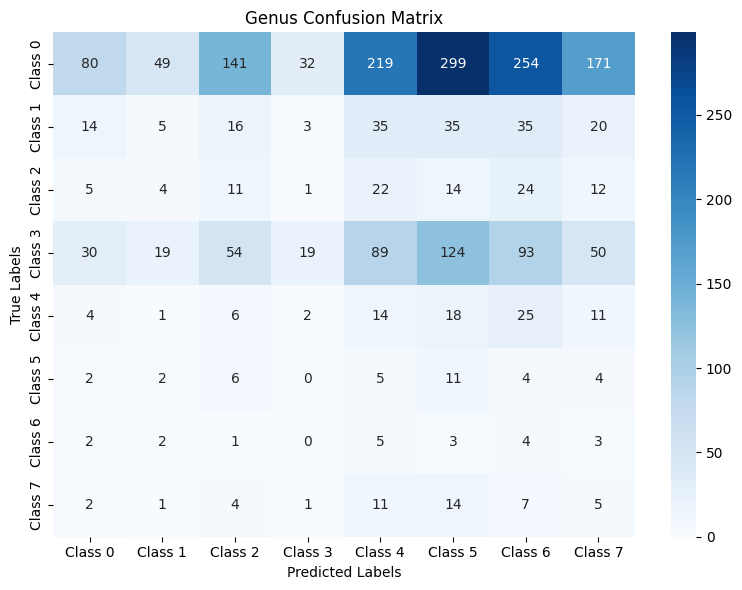

ROC AUC (macro): 0.5040048005228478
ROC AUC (micro): 0.4680076755111493
### Species Classification Report
              precision    recall  f1-score   support

     Class 0       0.12      0.01      0.03       202
     Class 1       0.29      0.00      0.00      1044
     Class 2       0.02      0.01      0.01       163
     Class 3       0.05      0.17      0.08        93
     Class 4       0.08      0.06      0.07       142
     Class 5       0.24      0.06      0.10       336
     Class 6       0.04      0.14      0.06        81
     Class 7       0.02      0.26      0.04        34
     Class 8       0.01      0.25      0.02        20
     Class 9       0.02      0.18      0.04        44

    accuracy                           0.04      2159
   macro avg       0.09      0.12      0.04      2159
weighted avg       0.20      0.04      0.03      2159



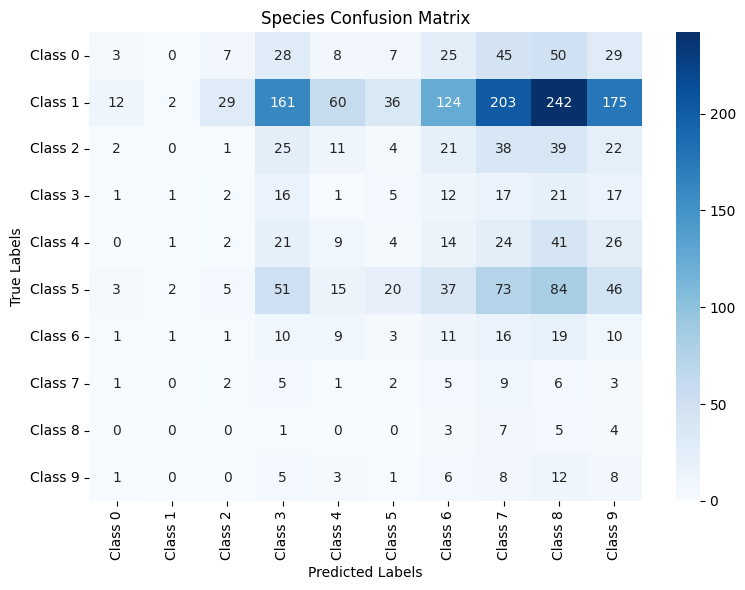

ROC AUC (macro): 0.5077900300404851
ROC AUC (micro): 0.4660593896351191


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def evaluate_and_plot(y_true, y_pred, title):
    class_labels = np.unique(np.concatenate((y_true, y_pred)))
    
    # Binarize labels for ROC AUC
    y_true_bin = label_binarize(y_true, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)
    
    # Classification report
    print(f"### {title} Classification Report")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in class_labels]))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Class {i}" for i in class_labels],
                yticklabels=[f"Class {i}" for i in class_labels])
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
    
    # ROC AUC Scores
    print("ROC AUC (macro):", roc_auc_score(y_true_bin, y_pred_bin, average='macro'))
    print("ROC AUC (micro):", roc_auc_score(y_true_bin, y_pred_bin, average='micro'))

# Evaluate Family
evaluate_and_plot(y_family_test_enc, y_family_pred, "Family")

# Evaluate Genus
evaluate_and_plot(y_genus_test_enc, y_genus_pred, "Genus")

# Evaluate Species
evaluate_and_plot(y_species_test_enc, y_species_pred, "Species")


* **Family classifier performed best**, with high AUC and classification scores.
* **Genus and species classifiers struggled**, likely due to class imbalance or model limitations.
* The confusion matrices provided useful visual insight into class-level performance patterns.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

### (b) Determine which family is the majority

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

## 3. ISLR 12.6.2